In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 2

encoder_inputs = keras.Input(shape=(88, 1))
x = layers.Conv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(encoder_inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same', dilation_rate=2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
encoder = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(88 * 8)(x)
x = layers.Reshape((88, 8))(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)
decoded = layers.Cropping1D(cropping=(0, 264))(decoded)  # Crop to the desired output shape
decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum((data - reconstruction) ** 2, axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute the mean, log variance, and sample from the latent space
        z_mean, z_log_var, z = self.encoder(x, training=False)

        # Generate samples from the latent space
        reconstructed_x = self.decoder(z, training=False)

        # Compute the reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum((x - reconstructed_x) ** 2, axis=(1, 2))
        )

        # Compute the KL divergence loss
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        # Compute the total loss as the sum of reconstruction loss and KL divergence loss
        total_loss = reconstruction_loss + kl_loss

        # Update the metrics
        self.compiled_metrics.update_state(y, reconstructed_x)

        # Return a dict mapping metric names to current value,
        # including the loss and other metrics
        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 88, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 88, 8)        32          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 44, 8)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 44, 16)       400         ['max_pooling1d[0][0]']          
                                                                                            

In [3]:
from sklearn.preprocessing import MinMaxScaler

features = pd.read_csv('features.csv')
labels = pd.read_csv('labels.csv')
(x_train, x_test, y_train, y_test) = train_test_split(features, labels, test_size=0.2, random_state=42)

y_train_labels = y_train
y_test_labels = y_test

#print(x_train)
#print(x_test)
#print(y_train)
#print(y_test)

# Convert columns to NumPy arrays
x_train_features = x_train.values
x_test_features = x_test.values

# Apply scaling to the features
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train_features)
x_test = scaler.transform(x_test_features)

#print(x_train)
#print(x_test)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [4]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, batch_size=128, epochs=5, validation_data=(x_test, y_test))
#vae.fit(x_train, batch_size=128, epochs=5, validation_data=(x_test, y_test, None))
#vae.fit(x_train, batch_size=128, epochs=5)

Epoch 1/5
66/66 [==============================] - 3s 17ms/step - loss: 1.5788 - reconstruction_loss: 1.4181 - kl_loss: 0.0025 - val_total_loss: 1.1114 - val_reconstruction_loss: 1.1095 - val_kl_loss: 0.0018
Epoch 2/5
66/66 [==============================] - 1s 14ms/step - loss: 1.1076 - reconstruction_loss: 1.0766 - kl_loss: 0.0017 - val_total_loss: 0.9601 - val_reconstruction_loss: 0.9586 - val_kl_loss: 0.0016
Epoch 3/5
66/66 [==============================] - 1s 14ms/step - loss: 1.0310 - reconstruction_loss: 1.0167 - kl_loss: 0.0012 - val_total_loss: 0.9357 - val_reconstruction_loss: 0.9352 - val_kl_loss: 5.4011e-04
Epoch 4/5
66/66 [==============================] - 1s 14ms/step - loss: 1.0077 - reconstruction_loss: 0.9904 - kl_loss: 4.6201e-04 - val_total_loss: 0.9034 - val_reconstruction_loss: 0.9030 - val_kl_loss: 3.2784e-04
Epoch 5/5
66/66 [==============================] - 1s 14ms/step - loss: 0.9680 - reconstruction_loss: 0.9700 - kl_loss: 2.7838e-04 - val_total_loss: 0.9058 

In [5]:
#print(x_test.shape)
#print(y_test.shape)

validation_loss = vae.evaluate(x_test, y_test)
print("Validation Loss:", validation_loss)


66/66 [==============================] - 0s 2ms/step - total_loss: 0.9574 - reconstruction_loss: 0.9571 - kl_loss: 2.5382e-04
Validation Loss: [0.9573541879653931, 0.9571003913879395, 0.00025382390595041215]


66/66 [==============================] - 0s 1ms/step


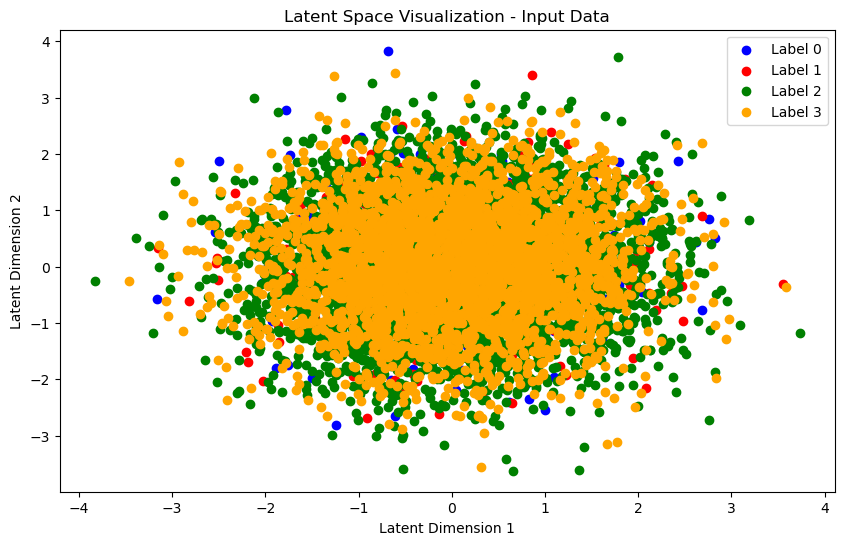

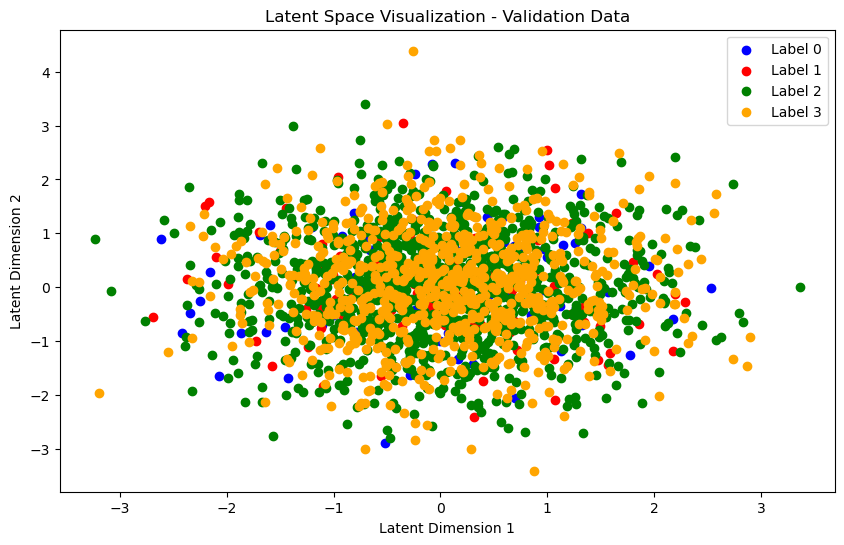

In [21]:
import matplotlib.pyplot as plt

# encode data into the latent space
_, _, encoded_x_train = vae.encoder.predict(x_train)
_, _, encoded_x_test = vae.encoder.predict(x_test)

label_colors = {0: 'blue', 1: 'red', 2: 'green', 3: 'orange'}

# input data
plt.figure(figsize=(10, 6))
for label in range(4):
    indices_train = np.where(y_train == label)[0]
    plt.scatter(encoded_x_train[indices_train, 0], encoded_x_train[indices_train, 1], c=label_colors[label],
                label='Label {}'.format(label))
plt.title('Latent Space Visualization - Input Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.show()

# validation data
plt.figure(figsize=(10, 6))
for label in range(4):
    indices_test = np.where(y_test == label)[0]
    plt.scatter(encoded_x_test[indices_test, 0], encoded_x_test[indices_test, 1], c=label_colors[label],
                label='Label {}'.format(label))
plt.title('Latent Space Visualization - Validation Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.show()



66/66 [==============================] - 0s 2ms/step
(2092, 88, 1)
[[0.44120556]
 [0.43416923]
 [0.4331523 ]
 ...
 [0.43825787]
 [0.4306121 ]
 [0.43779534]]
[[0.30026898]
 [0.307215  ]
 [0.30596906]
 ...
 [0.31156045]
 [0.2995646 ]
 [0.30772695]]


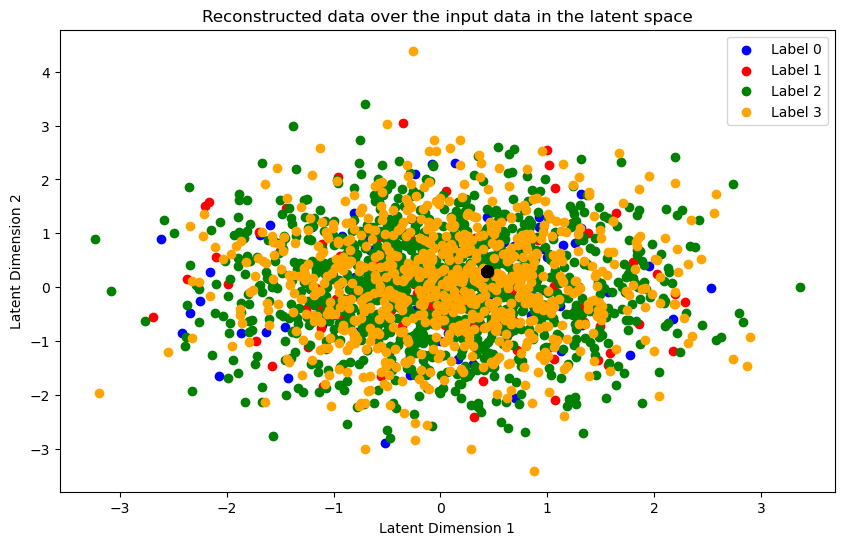

In [25]:
# Reconstruct the validation data using the VAE
reconstructed_x_test = vae.decoder.predict(encoded_x_test)
print(reconstructed_x_test.shape)
print(reconstructed_x_test[:,0])
print(reconstructed_x_test[:,1])

# Plot the encoded vectors for the validation data
plt.figure(figsize=(10, 6))
for label in range(4):
    indices_test = np.where(y_test == label)[0]
    plt.scatter(encoded_x_test[indices_test, 0], encoded_x_test[indices_test, 1], c=label_colors[label],
                label='Label {}'.format(label))
plt.title('Reconstructed data over the input data in the latent space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()

# Overlay all the reconstructed validation data points on the plot
plt.scatter(reconstructed_x_test[:, 0], reconstructed_x_test[:, 1], c='black', alpha=0.5)
plt.show()


262/262 [==============================] - 0s 901us/step


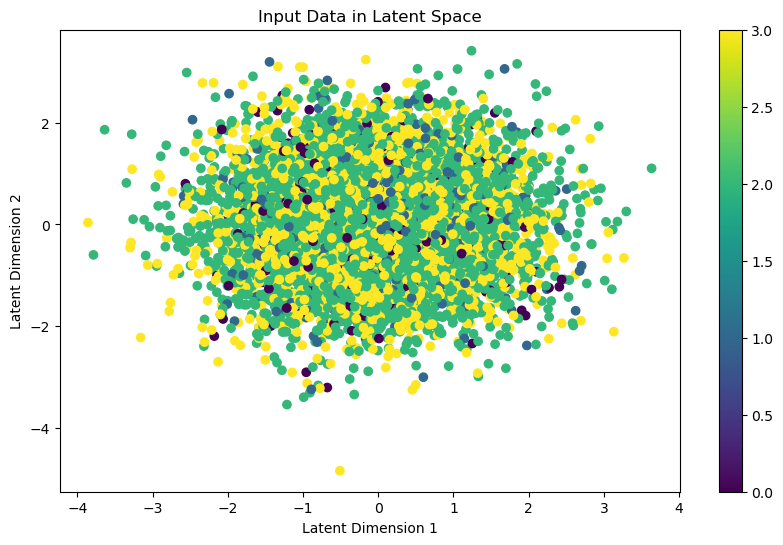

66/66 [==============================] - 0s 2ms/step


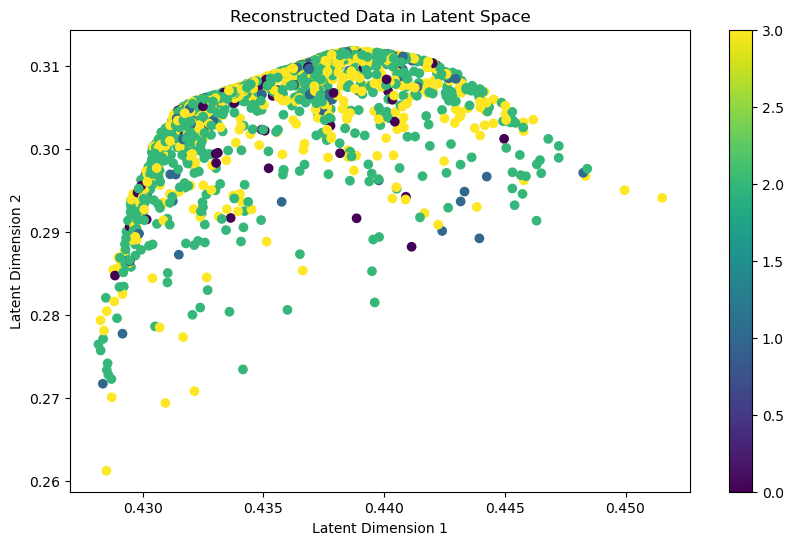

In [20]:
import matplotlib.pyplot as plt

def plot_data_latent_space(encoder, x_data, y_data):
    _, _, z = encoder.predict(x_data)
    plt.scatter(z[:, 0], z[:, 1], c=y_data)
    plt.colorbar()
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Input Data in Latent Space")
    plt.show()

def plot_reconstructed_latent_space(encoder, decoder, x_data, y_data):
    _, _, z = encoder.predict(x_data)
    reconstructed_data = decoder.predict(z)
    plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=y_data)
    plt.colorbar()
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Reconstructed Data in Latent Space")
    plt.show()
    
plt.figure(figsize=(10, 6))
plot_data_latent_space(encoder, x_train, y_train) 

plt.figure(figsize=(10, 6))
plot_reconstructed_latent_space(encoder, decoder, x_test, y_test)